In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

The last day of the data is ('2017-08-23',).
The first day of the last year is 2016-09-20.


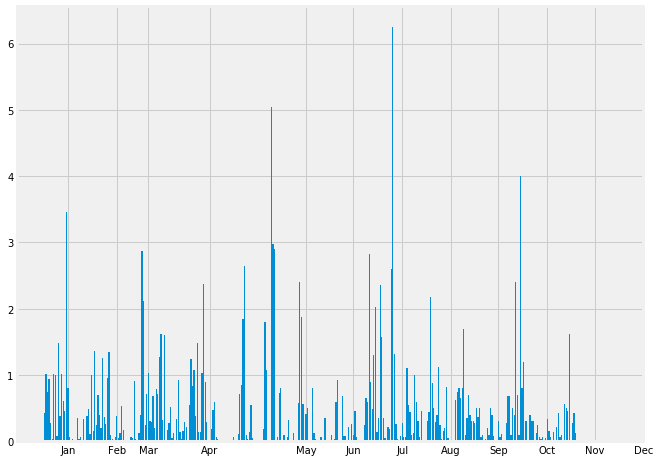

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).all()[0]
print(f'The last day of the data is {last_day}.')
first_day = dt.date(2017, 9, 20) - dt.timedelta(days=365)
print(f'The first day of the last year is {first_day}.')
# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= first_day).all()
last_year
# Save the query results as a Pandas DataFrame and set the index to the date column
dataframe = pd.DataFrame(last_year, columns = ['Date', 'Precipitation'])
dataframe.set_index('Date', inplace=True)
dataframe
# Sort the dataframe by date
dataframe.sort_values(by = 'Date').groupby('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,8))
plt.bar(dataframe.index, dataframe['Precipitation'])
ticks = [0,31,51,90,151,181,212,243,273,304,334,365]
ticks = [num + 15 for num in ticks]
months = ['Jan', 'Feb', 'Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ticks = ticks, labels = months)
plt.show()



plt.show()

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
statistics = dataframe.describe()
statistics

,Precipitation
count,1866.000000
mean,0.161281
std,0.420638
min,0.000000
25%,0.000000
50%,0.010000
75%,0.120000
max,6.250000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Measurement.station)
unique_stations = num_stations.distinct().count()

print(f'There are {unique_stations} stations.')

There are 9 stations.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = session.query(Measurement.station, func.count(Measurement.station))
active_station = active.group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_df = pd.DataFrame(active_station, columns = ['Station', 'Count'])
active_df.set_index('Station', inplace = True)
active_df

,Count
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperature = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
final_temp_data = temperature.group_by(Measurement.station).order_by(func.count())
final_temp_df = pd.DataFrame(final_temp, columns = ['Station', 'Lowest Temp', 'Highest Temp', 'Average Temp'])
final_temp_df.set_index('Station', inplace = True)
final_temp = pd.DataFrame(final_temp_df.iloc[-1]).transpose()
final_temp_data.all()

[('USC00518838', 58.0, 83.0, 72.72407045009784),
 ('USC00517948', 58.0, 87.0, 74.68440233236151),
 ('USC00511918', 53.0, 87.0, 71.61596766043456),
 ('USC00514830', 58.0, 85.0, 74.8732970027248),
 ('USC00516128', 58.0, 84.0, 70.91500765696784),
 ('USC00519523', 56.0, 85.0, 74.5436493068565),
 ('USC00513117', 59.0, 85.0, 72.68918420081211),
 ('USC00519397', 56.0, 87.0, 74.55323054331865),
 ('USC00519281', 54.0, 85.0, 71.66378066378067)]

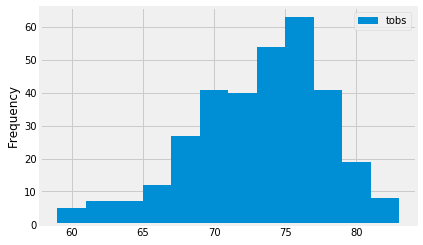

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_station = active_station[0][0]
#print(top_station)
last_year_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == top_station).filter(Measurement.date >= first_day).order_by(Measurement.date).all()

last_temp_df = pd.DataFrame(last_year_temp, columns = ['Date', 'TOBS'])
plt.hist(last_temp_df['TOBS'], bins = 12)
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()

                                                                                                                                     

![precipitation](Images/station-histogram.png)

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-02-20', '2017-02-26')
trip_temps

[(61.0, 69.48837209302326, 75.0)]

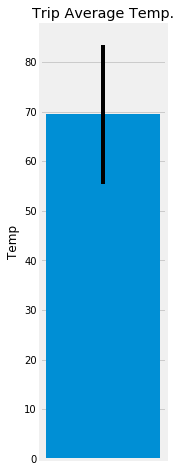

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temps_df = pd.DataFrame(trip_temps, columns = ['tmin','avg','tmax'])
tavg = trip_temps_df['avg']
tmin_tmax = trip_temps_df.iloc[0]['tmax'] - trip_temps_df.iloc[0]['tmin']
plt.figure(figsize=(2,8))
plt.bar(trip_temps_df.index, trip_temps_df['avg'], yerr = tmin_tmax)
plt.xticks(ticks = [])
plt.ylabel('Temp')
plt.title('Trip Average Temp.')
plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_first_day = '2017-02-20'
trip_last_day = '2017-02-26'

trip_data = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation)
trip_data_all = trip_data.filter(Measurement.date >= trip_first_day).filter(Measurement.date <= trip_last_day).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).label('total_prcp').desc()).all()
trip_data_df = pd.DataFrame(trip_data_all, columns = ['Station', 'City','Latitude','Longitude','Elevation']).set_index('Station')
trip_data_df


,City,Latitude,Longitude,Elevation
Station,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9


## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
